In [1]:
import glob
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import numpy as np
import re
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


## Functions

In [10]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence


def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 만들겁니다
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer


def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()
    
    
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, 
        tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.


## Data Preprocessing

In [3]:
# 텍스트파일 lyrics안에 있는 파일들 전체 선택
txt_file_path = './data/lyrics/*'
txt_list = glob.glob(txt_file_path)

raw_corpus = []
        
for txt_file in txt_list:
    with open(txt_file, "r", encoding='UTF8') as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)
        
print('데이터 크기:', len(raw_corpus))
print('Examples:\n', raw_corpus[:3])

# 여기에 정제된 문장을 모을겁니다
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
    
tensor, tokenizer = tokenize(corpus)

src_input = tensor[:, :-1]
target_input = tensor[:, 1:]
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, target_input, test_size=0.2, random_state=1)


# hyperparameter
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE



VOCAB_SIZE = tokenizer.num_words + 1    # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지않은 0:를 포함하여 12001개

# train,  validation 데이터셋 나누기
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)



데이터 크기: 187088
Examples:
 ["Busted flat in Baton Rouge, waitin' for a train", "And I's feelin' near as faded as my jeans", 'Bobby thumbed a diesel down, just before it rained']
[[   2 3604 1691 ...    0    0    0]
 [   2    8    5 ...    0    0    0]
 [   2  804 7655 ...    0    0    0]
 ...
 [   2    5   22 ...    0    0    0]
 [   2    5   22 ...    0    0    0]
 [   2    5   22 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f375c3a73d0>


In [4]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.drop1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 100
hidden_size = 100
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1200100   
_________________________________________________________________
lstm (LSTM)                  multiple                  80400     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lstm_1 (LSTM)                multiple                  80400     
_________________________________________________________________
dense (Dense)                multiple                  1212101   
Total params: 2,573,001
Trainable params: 2,573,001
Non-trainable params: 0
_________________________________________________________________


In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
history = model.fit(dataset,
          epochs=7,
          validation_data=val_dataset,
          verbose=1)

Epoch 1/7
549/549 [==============================] - 469s 847ms/step - loss: 0.6155 - accuracy: 0.9720 - val_loss: 0.1659 - val_accuracy: 0.9760
Epoch 2/7
549/549 [==============================] - 467s 850ms/step - loss: 0.1618 - accuracy: 0.9759 - val_loss: 0.1556 - val_accuracy: 0.9763
Epoch 3/7
549/549 [==============================] - 467s 850ms/step - loss: 0.1528 - accuracy: 0.9765 - val_loss: 0.1484 - val_accuracy: 0.9770
Epoch 4/7
549/549 [==============================] - 467s 851ms/step - loss: 0.1476 - accuracy: 0.9769 - val_loss: 0.1447 - val_accuracy: 0.9772
Epoch 5/7
549/549 [==============================] - 468s 852ms/step - loss: 0.1441 - accuracy: 0.9772 - val_loss: 0.1414 - val_accuracy: 0.9776
Epoch 6/7
549/549 [==============================] - 468s 852ms/step - loss: 0.1411 - accuracy: 0.9775 - val_loss: 0.1389 - val_accuracy: 0.9778
Epoch 7/7
549/549 [==============================] - 468s 852ms/step - loss: 0.1386 - accuracy: 0.9777 - val_loss: 0.1367 - val_ac

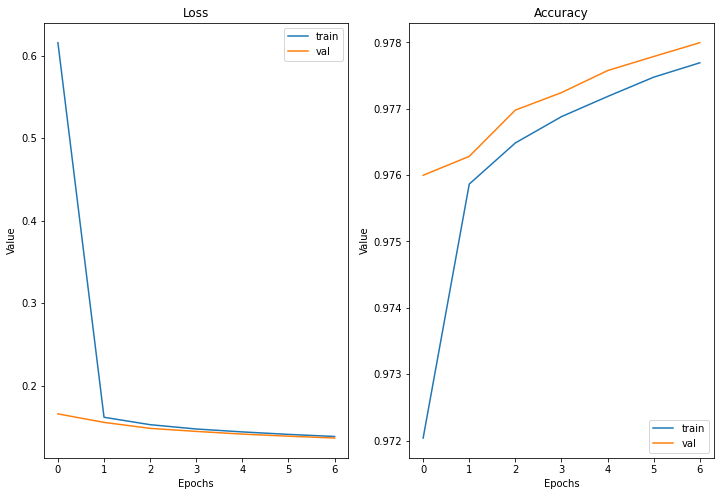

In [17]:
plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [16]:
generate_text(model, tokenizer, init_sentence="okay", max_len=20)

'okay i m been a <unk> <end> '

## 회고
---

LSTM 두개 사이의 Dropout을 0.3으로 지정했으며, 데이터 전처리 과정을 거쳐 특수문자 제거, 토크나이저 생성을 했고, generate_text를 이용해 가사를 생성하였으나, 말처럼 쉽게 generate 되지는 않았다.